In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy.odr as odr

In [145]:
abs_db = pd.read_csv('../data/absorption_data.csv', delimiter="\t")
print(abs_db.head())

   drops  av. [au]  std [au]
0      6  0.033502  0.004359
1      5  0.015381  0.002666
2      4  0.024404  0.011011
3      3  0.009573  0.007395
4      2  0.007729  0.002858


In [146]:
purif_fact = 17.7 / 44.5
extraction_rate = 0.61  # mg/g
extraction_rate_err = 0.01  # mg/g
spinach_mass = 10  # g
spinach_mass_err = 1  # g
chlorophyll_molar_mass = 893.51  # g/mol
chlorophyll_molar_mass_err = 0.01  # g/mol
acetone_vol = 0.16  # l
mole_per_liter = purif_fact*extraction_rate*spinach_mass/1000/chlorophyll_molar_mass/acetone_vol
mole_per_liter_err = mole_per_liter * np.sqrt((extraction_rate_err/extraction_rate)**2 + (spinach_mass_err/spinach_mass)**2 + (chlorophyll_molar_mass_err/chlorophyll_molar_mass)**2)

l_per_drop = 0.025 / 1000  # l per drop (duh)
l_per_drop_err = 0.001 / 1000  # l per drop (duh)
cuvette_length = 1.0  # cm
cuvette_volume = 0.0033  # l
cuvette_volume_err = 0.0001  # l
mole_per_drop = mole_per_liter * l_per_drop / 3  # Solution was diluted 1:3
mole_per_drop_err = mole_per_drop * np.sqrt((mole_per_liter_err/mole_per_liter)**2 + (l_per_drop_err/l_per_drop)**2)

abs_db["molar concentration [M]"] = abs_db["drops"] * mole_per_drop / cuvette_volume
abs_db["std [M]"] = abs_db["molar concentration [M]"] * np.sqrt((mole_per_drop_err/mole_per_drop)**2 + (cuvette_volume_err/cuvette_volume)**2)

print(abs_db.head())


   drops  av. [au]  std [au]  molar concentration [M]       std [M]
0      6  0.033502  0.004359             2.571460e-07  2.907799e-08
1      5  0.015381  0.002666             2.142883e-07  2.423166e-08
2      4  0.024404  0.011011             1.714307e-07  1.938533e-08
3      3  0.009573  0.007395             1.285730e-07  1.453900e-08
4      2  0.007729  0.002858             8.571533e-08  9.692664e-09


In [147]:
def fit_func(x, a, b):
    return a * x + b

def odr_func(p, x):
    return p[0] * x + p[1]

In [148]:
linear = odr.Model(odr_func)
data = odr.RealData(abs_db["molar concentration [M]"], abs_db["av. [au]"], sy=abs_db["std [au]"], sx=abs_db["std [M]"])
myodr = odr.ODR(data, linear, beta0=[1, 1])
out = myodr.run()

print(out.beta)
print(out.sd_beta)

a, b = out.beta
a_err, b_err = out.sd_beta

y_model = odr_func((a, b), abs_db["molar concentration [M]"])
chi_square = np.sum(((abs_db["av. [au]"] - y_model) ** 2) / abs_db["std [au]"]**2)
degrees_of_freedom = len(abs_db["av. [au]"]) - 2
chi_square_red = chi_square / degrees_of_freedom
print(chi_square_red)

[ 1.22844952e+05 -4.33866894e-03]
[2.02395146e+04 1.75022747e-03]
2.259808339052738


In [149]:
# popt, pcov = curve_fit(fit_func, abs_db["molar concentration [M]"], abs_db["av. [au]"], sigma=abs_db["std [au]"], absolute_sigma=True)

# a, b = popt
# a_err, b_err = np.sqrt(np.diag(pcov))

# print(a, b)
# print(a_err, b_err)

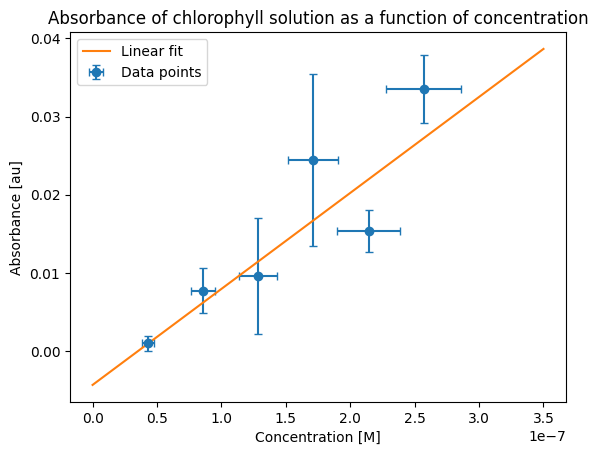

In [150]:
plt.errorbar(abs_db["molar concentration [M]"], abs_db["av. [au]"], yerr=abs_db["std [au]"], xerr=abs_db["std [M]"] ,fmt='o', capsize=3, label="Data points")

xs = np.linspace(0, 3.5*10**(-7), 1000)
plt.plot(xs, fit_func(xs, a, b), label="Linear fit")

plt.title("Absorbance of chlorophyll solution as a function of concentration")
plt.xlabel("Concentration [M]")
plt.ylabel("Absorbance [au]")

plt.legend()
plt.show()

In [151]:
print(f"$\epsilon$ = ({round(a/cuvette_length)} +/- {round(a_err/cuvette_length)}) $M^{-1}$ $cm^{-1}$")  # choosing greater peak at the (theoretical) value of around 430 nm

$\epsilon$ = (122845 +/- 20240) $M^-1$ $cm^-1$


In [152]:
spect_data = pd.read_csv('../data/spectrum_data.csv', delimiter="\t")
print(spect_data.head())

   lambda (nm)  A (1 drop)  A (4 drops)  A (6 drops)
0      365.036         0.0          0.0          0.0
1      365.207         0.0          0.0          0.0
2      365.378         0.0          0.0          0.0
3      365.549         0.0          0.0          0.0
4      365.721         0.0          0.0          0.0


In [153]:
# Find peaks in abosorption spectrum
vial_peak_cutoff_index = 150

peaks_indices1, peak1_properties = find_peaks(spect_data["A (1 drop)"][vial_peak_cutoff_index:], width=10, height=0.1, distance=100)
peaks_indices4, peak2_properties = find_peaks(spect_data["A (4 drops)"][vial_peak_cutoff_index:], width=10, height=0.2, distance=100)
peaks_indices6, peak3_properties = find_peaks(spect_data["A (6 drops)"][vial_peak_cutoff_index:], width=10, height=0.2, distance=100)

print(peaks_indices1, peak1_properties)
print(peaks_indices4, peak2_properties)
print(peaks_indices6, peak3_properties)

peak1_index = np.mean([peaks_indices1[0], peaks_indices4[0], peaks_indices6[0]]) + vial_peak_cutoff_index
peak2_index = np.mean([peaks_indices1[1], peaks_indices4[1], peaks_indices6[1]]) + vial_peak_cutoff_index

peak1_wavelength = spect_data["lambda (nm)"][int(peak1_index)]
peak2_wavelength = spect_data["lambda (nm)"][int(peak2_index)]

print(spect_data["lambda (nm)"][int(peaks_indices1[0]) + vial_peak_cutoff_index])
print(spect_data["lambda (nm)"][int(peaks_indices4[0]) + vial_peak_cutoff_index])
print(spect_data["lambda (nm)"][int(peaks_indices6[0]) + vial_peak_cutoff_index])



[ 239 1582] {'peak_heights': array([0.183, 0.111]), 'prominences': array([0.052, 0.048]), 'left_bases': array([  0, 970]), 'right_bases': array([1966, 1966]), 'widths': array([103., 117.]), 'width_heights': array([0.157, 0.087]), 'left_ips': array([ 183., 1516.]), 'right_ips': array([ 286., 1633.])}
[ 245 1582] {'peak_heights': array([0.615, 0.313]), 'prominences': array([0.251, 0.224]), 'left_bases': array([  8, 930]), 'right_bases': array([1979, 1979]), 'widths': array([115.26666667, 118.66666667]), 'width_heights': array([0.4895, 0.201 ]), 'left_ips': array([ 169.83333333, 1516.        ]), 'right_ips': array([ 285.1       , 1634.66666667])}
[ 236 1582] {'peak_heights': array([1.321, 0.471]), 'prominences': array([0.689, 0.364]), 'left_bases': array([  7, 946]), 'right_bases': array([1968, 1968]), 'widths': array([ 82.58333333, 115.33333333]), 'width_heights': array([0.9765, 0.289 ]), 'left_ips': array([ 193.16666667, 1518.66666667]), 'right_ips': array([ 275.75, 1634.  ])}
431.552
4

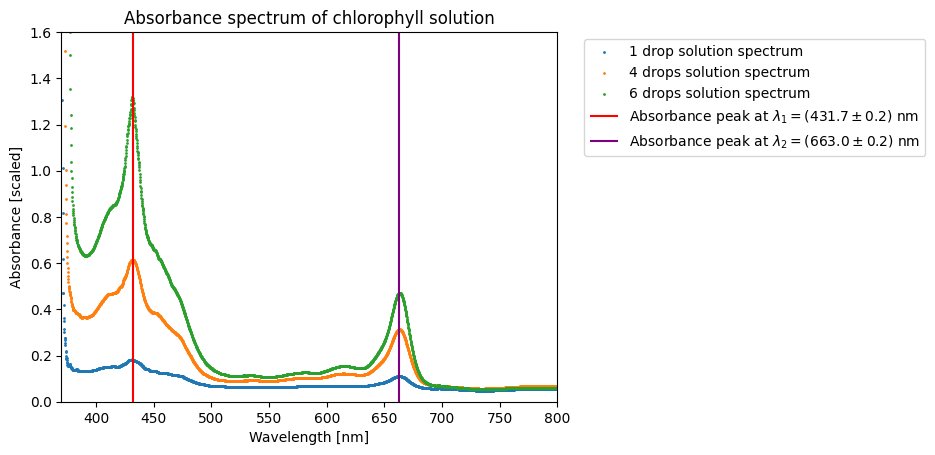

In [154]:
plt.scatter(spect_data["lambda (nm)"], spect_data["A (1 drop)"], label="1 drop solution spectrum", s=1)
plt.scatter(spect_data["lambda (nm)"], spect_data["A (4 drops)"], label="4 drops solution spectrum", s=1)
plt.scatter(spect_data["lambda (nm)"], spect_data["A (6 drops)"], label="6 drops solution spectrum", s=1)

plt.vlines(peak1_wavelength, 0, 1.6, label=f"Absorbance peak at $\lambda_1 = \left({peak1_wavelength:.1f} \pm 0.2\\right)$ nm", colors="r")
plt.vlines(peak2_wavelength, 0, 1.6, label=f"Absorbance peak at $\lambda_2 = \left({peak2_wavelength:.1f} \pm 0.2\\right)$ nm", colors='purple')

plt.xlim(370, 800)
plt.ylim(0, 1.6)

plt.title("Absorbance spectrum of chlorophyll solution")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Absorbance [scaled]")

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()